In [14]:
%matplotlib inline

from Basilisk.utilities import (
    SimulationBaseClass,
    macros,
    unitTestSupport,
    simulationArchTypes
)

from Basilisk.simulation import (
    spacecraft,
    extForceTorque,
    simpleNav
)

from Basilisk.fswAlgorithms import (
    inertial3D,
    attTrackingError,
    mrpFeedback
)

from Basilisk.architecture import messaging

import numpy as np
import matplotlib.pyplot as plt

In [18]:
class PythonMRPPD(simulationArchTypes.PythonModelClass):
    def __init__(self, modelName, modelActive=True, modelPriority=-1):
        super(PythonMRPPD, self).__init__(modelName, modelActive, modelPriority)

        # Proportional gain term used in control
        self.K = 0
        # Derivative gain term used in control
        self.P = 0
        # Input guidance structure message
        self.guidInMsg = messaging.AttGuidMsgReader()
        # Output body torque message name
        self.cmdTorqueOutMsg = messaging.CmdTorqueBodyMsg()
        
        self._should_print_once = True
        
        self.total_reward = 0.0
        
    def _print_once(self, arg):
        if self._should_print_once:
            print(arg)

    def reset(self, currentTime):
        """
        The reset method is used to clear out any persistent variables that need to get changed
        when a task is restarted.  This method is typically only called once after selfInit/crossInit,
        but it should be written to allow the user to call it multiple times if necessary.
        :param currentTime: current simulation time in nano-seconds
        :return: none
        """
        return

    def updateState(self, currentTime):
        """
        The updateState method is the critical worker method for a given Basilisk class.  It
        will get called periodically at the rate specified in the Python task that the model is
        attached to.  It persists and anything can be done inside of it.  If you have realtime
        requirements though, be careful about how much processing you put into a Python updateState
        method.  You could easily detonate your sim's ability to run in realtime.
        :param currentTime: current simulation time in nano-seconds
        :return: none
        """
        # read input message
        guidMsgBuffer = self.guidInMsg()
        self._print_once(f"sigma_BR = {guidMsgBuffer.sigma_BR} and omega_BR_B = {guidMsgBuffer.omega_BR_B}")
        # create output message buffer
        torqueOutMsgBuffer = messaging.CmdTorqueBodyMsgPayload()

        # compute control solution
        lrCmd = np.array(guidMsgBuffer.sigma_BR) * self.K + np.array(guidMsgBuffer.omega_BR_B) * self.P
        torqueOutMsgBuffer.torqueRequestBody = (-lrCmd).tolist()
        self._print_once(f"Output torque = {torqueOutMsgBuffer.torqueRequestBody}")

        self.cmdTorqueOutMsg.write(torqueOutMsgBuffer, currentTime, self.moduleID)
        
        # Calculate what the 'reward' would be if this was the DRL situation
        self.total_reward += (-10.0 * np.linalg.norm(guidMsgBuffer.sigma_BR))
        if currentTime > macros.min2nano(8.0):
            print(f"At time {currentTime} the orientaiton is {guidMsgBuffer.sigma_BR} and the total reward is be {self.total_reward}")

        def print_output():
            """Sample Python module method"""
            print(currentTime * 1.0E-9)
            print(torqueOutMsgBuffer.torqueRequestBody)
            print(guidMsgBuffer.sigma_BR)
            print(guidMsgBuffer.omega_BR_B)
            
        # print_output()
        # from IPython.core.debugger import Pdb; Pdb().set_trace()
        self._should_print_once = False

        return

In [19]:
class Simulation:
    def __init__(self, tumble, desired_orientation, num_log_points = 150):
        self.sim_task_name = "simTask"
        self.sim_proc_name = "simProc"
        self.py_task_name = "pyTask"
        self.py_proc_name = "pyProc"
        
        self.sim = SimulationBaseClass.SimBaseClass()
        self.sim_max_time = macros.min2nano(10.0)
        self.sim_dt = macros.sec2nano(0.1)
        
        self.dyn_process = self.sim.CreateNewProcess(self.sim_proc_name, 10)
        self.dyn_process.addTask(self.sim.CreateNewTask(self.sim_task_name, self.sim_dt))
        
        # Add the Python module task and process
        self.py_proc = self.sim.CreateNewPythonProcess(self.py_proc_name, 9)
        self.py_proc.createPythonTask(self.py_task_name, self.sim_dt, True, -1)
        
        
        # Setup the spaecraft model.
        # The spacecraft model's documentation is found at
        # http://hanspeterschaub.info/basilisk/Documentation/simulation/dynamics/spacecraft/spacecraft.html
        self.spacecraft = spacecraft.Spacecraft()
        self.spacecraft.ModelTag = "bsk-Sat"
        
        # Define the inertial properties
        self.I = [900., 0., 0.,
                  0., 800., 0.,
                  0., 0., 600.]
        
        self.spacecraft.hub.mHub = 750.0  # spacecraft mass [kg]
        self.spacecraft.hub.r_BcB_B = [[0.0], [0.0], [0.0]]  # m - position vector of body-fixed point B relative to CM
        self.spacecraft.hub.IHubPntBc_B = unitTestSupport.np2EigenMatrix3d(self.I)
        self.spacecraft.hub.sigma_BNInit = [[0.1], [0.2], [-0.3]]  # sigma_BN_B
        self.spacecraft.hub.omega_BN_BInit = tumble  # [rad/s]
        
        # Add the spacecraft object to the simulation process
        self.sim.AddModelToTask(self.sim_task_name, self.spacecraft)
        
        # Setup the external control torque
        self.ex_torque = extForceTorque.ExtForceTorque()
        self.ex_torque.ModelTag = "externalDisturbance"
        self.spacecraft.addDynamicEffector(self.ex_torque)
        self.sim.AddModelToTask(self.sim_task_name, self.ex_torque)
        
        # Setup the navigation sensor module which controls the
        # craft's attitude, rate, and position
        self.nav = simpleNav.SimpleNav()
        self.nav.ModelTag = "simpleNavigation"
        self.sim.AddModelToTask(self.sim_task_name, self.nav)
        
        # Setup the inertial 3D guidance module
        self._i3D = inertial3D.inertial3DConfig()
        self.i3D = self.sim.setModelDataWrap(self._i3D)
        self.i3D.ModelTag = "inertial3D"
        self.sim.AddModelToTask(self.sim_task_name, self.i3D, self._i3D)
        self._i3D.sigma_R0N = desired_orientation
        
        # Setup the attitude tracking error evaluation module
        self._attErr = attTrackingError.attTrackingErrorConfig()
        self.attErr = self.sim.setModelDataWrap(self._attErr)
        self.attErr.ModelTag = "attErrorInertial3D"
        self.sim.AddModelToTask(self.sim_task_name, self.attErr, self._attErr)
        
        # Setup the Python MRP PD control module
        self.py_mrp_pd = PythonMRPPD("pyMDP_PD", True, 100)
        self.py_mrp_pd.K = 3.5
        self.py_mrp_pd.P = 30.0
        self.py_proc.addModelToTask(self.py_task_name, self.py_mrp_pd)
        
        # Set up recording of values *before* the simulation is initialized
        t = unitTestSupport.samplingTime(self.sim_max_time, self.sim_dt, num_log_points)
        self.attitude_err_log = self._attErr.attGuidOutMsg.recorder(t)
        self.mrp_log = self.py_mrp_pd.cmdTorqueOutMsg.recorder(t)
        self.sim.AddModelToTask(self.sim_task_name, self.attitude_err_log)
        self.sim.AddModelToTask(self.sim_task_name, self.mrp_log)
        
        # Set up the messaging
        self.nav.scStateInMsg.subscribeTo(self.spacecraft.scStateOutMsg)
        self._attErr.attNavInMsg.subscribeTo(self.nav.attOutMsg)
        self._attErr.attRefInMsg.subscribeTo(self._i3D.attRefOutMsg)
        self.py_mrp_pd.guidInMsg.subscribeTo(self._attErr.attGuidOutMsg)
        self.ex_torque.cmdTorqueInMsg.subscribeTo(self.py_mrp_pd.cmdTorqueOutMsg)
        
    def run(self):
        self.sim.InitializeSimulation()
        # self.sim.ConfigureStopTime(self.sim_max_time)
        print(f"Overall stop time is {self.sim_max_time}")
        
        first_leg = self.sim_max_time / 2
        print(f"Simulating up until {first_leg}")
        self.sim.ConfigureStopTime(first_leg)
        self.sim.ExecuteSimulation()
        
        print(f"Simulating now until {self.sim_max_time}")
        self.sim.ConfigureStopTime(self.sim_max_time)
        self.sim.ExecuteSimulation()
        
    def get_plot_data(self):
        dataLr = self.mrp_log.torqueRequestBody
        dataSigmaBR = self.attitude_err_log.sigma_BR
        dataOmegaBR = self.attitude_err_log.omega_BR_B
        timeAxis = self.attitude_err_log.times()
        
        return dataLr, dataSigmaBR, dataOmegaBR, timeAxis
        
    def plot(dataLr, dataSigmaBR, dataOmegaBR, timeAxis):
        np.set_printoptions(precision=16)

        plt.figure(1)
        for idx in range(3):
            plt.plot(timeAxis * macros.NANO2MIN, dataSigmaBR[:, idx],
                     color=unitTestSupport.getLineColor(idx, 3),
                     label=r'$\sigma_' + str(idx) + '$')
        plt.legend(loc='lower right')
        plt.xlabel('Time [min]')
        plt.ylabel(r'Attitude Error $\sigma_{B/R}$')
        figureList = {}
        pltName = "1"
        figureList[pltName] = plt.figure(1)

        plt.figure(2)
        for idx in range(3):
            plt.plot(timeAxis * macros.NANO2MIN, dataLr[:, idx],
                     color=unitTestSupport.getLineColor(idx, 3),
                     label='$L_{r,' + str(idx) + '}$')
        plt.legend(loc='lower right')
        plt.xlabel('Time [min]')
        plt.ylabel('Control Torque $L_r$ [Nm]')
        pltName = "2" 
        figureList[pltName] = plt.figure(2)

        plt.figure(3)
        for idx in range(3):
            plt.plot(timeAxis * macros.NANO2MIN, dataOmegaBR[:, idx],
                     color=unitTestSupport.getLineColor(idx, 3),
                     label=r'$\omega_{BR,' + str(idx) + '}$')
        plt.legend(loc='lower right')
        plt.xlabel('Time [min]')
        plt.ylabel('Rate Tracking Error [rad/s] ')

Overall stop time is 600000000030
Simulating up until 300000000015.0
sigma_BR = [0.1, 0.2, -0.3] and omega_BR_B = [0.8, -0.6, 0.5]
Output torque = [-24.35, 17.3, -13.95]
Simulating now until 600000000030
At time 480100000000 the orientaiton is [-0.0004035544452517815, 0.00021211757320152363, -1.819586663506567e-05] and the total reward is be -8565.487491207268
At time 480200000000 the orientaiton is [-0.0004021414236865034, 0.00021109896011072845, -1.809060607983027e-05] and the total reward is be -8565.492036619962
At time 480300000000 the orientaiton is [-0.0004007291845723257, 0.00021008184652958228, -1.7985607728078698e-05] and the total reward is be -8565.49656477349
At time 480400000000 the orientaiton is [-0.00039931773907940775, 0.00020906623800589924, -1.7880871806464393e-05] and the total reward is be -8565.50107568331
At time 480500000000 the orientaiton is [-0.00039790709833297444, 0.0002080521400501838, -1.7776398536637913e-05] and the total reward is be -8565.50556936501


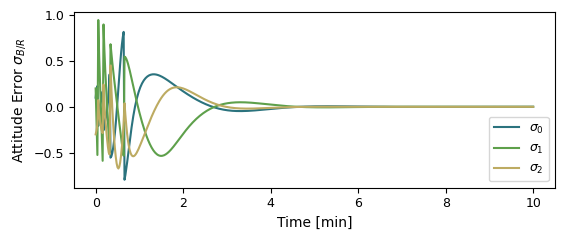

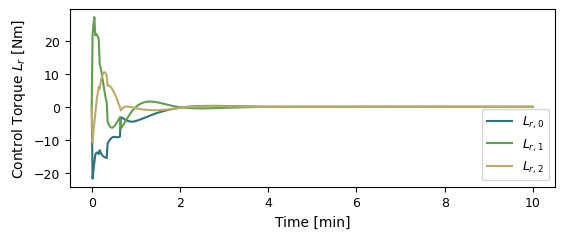

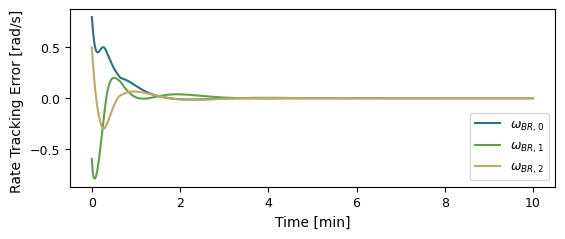

In [20]:
%%time
tumble = [[0.8], [-0.6], [0.5]]
desired_orientation = [0.0, 0.0, 0.0]

sim = Simulation(tumble, desired_orientation, num_log_points=500)
sim.run()
Simulation.plot(*sim.get_plot_data())

# Notes about usage of Basilisk with Ray

Basilisk is designed to be performant and, therefore, leverages compiled code from C, C++, and FORTRAN and provides a Python-based interface.
The SWIG library is used to provide bindings and unfortunately SWIG Python objects are _not_ serializable.
Ray pickles the remote definition and and returns from that remote function so one has to be careful not to return any SWIG objects, e.g., the simulation object.
Here we ensure that the remote function returns pickle-able data which we extracted from the SWIG objects.

(do_sim pid=31016) Overall stop time is 420000000030
(do_sim pid=31016) Simulating up until 210000000015.0
(do_sim pid=31016) Simulating now until 420000000030


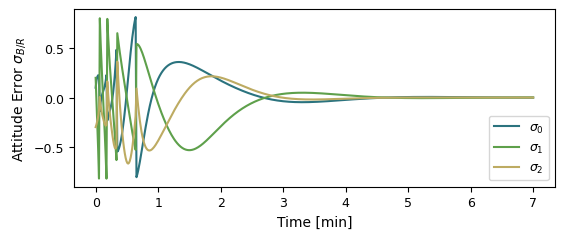

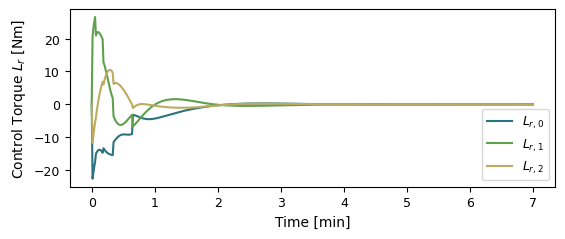

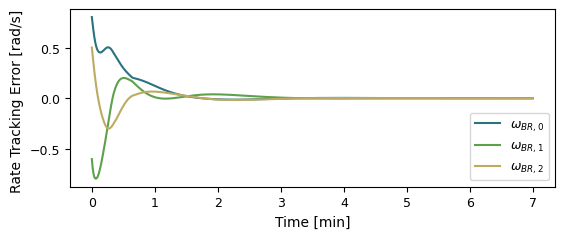

In [50]:
import ray

@ray.remote
def do_sim(desired_orientation):
    tumble = [[0.8], [-0.6], [0.5]]

    sim = Simulation(tumble, desired_orientation, num_log_points=500)
    sim.run()
    
    return sim.get_plot_data()

f = do_sim.remote([0.0]*3)
Simulation.plot(*ray.get(f))

#fs = [do_sim.remote([0.0]*3) for _ in range(2)]

#for i, f in enumerate(fs):
#    print(f"Showing results from simulation {i}")
#    Simulation.plot(*ray.get(f))
